# Определение перспективного источника трафика для Яндекс.Афиши

Цель проекта - определить выгодные источники трафика, чтобы правильно спланировать маркетинговый бюджет и повысить прибыльность Яндекс.Афиши.

Были изучены пользовательские данные с июня 2017 по конец мая 2018 года: такие, как логи с посещениями и заказами. Также была проанализирована статистика расходов на привлечение клиентов. Перед анализом данные прошли проверку и предобработку.

В ходе исследования мы изучили:
* как клиенты пользуются сервисом,
* когда делают первые покупки на сайте,
* сколько денег приносит компании каждый клиент,
* когда расходы на привлечение клиента окупаются.

Мы использовали когортный анализ для исследования показателей, что позволило нам не просто смотреть на данные в динамике, но и определить, чем вызваны изменения: текущими действиями или же решениями, принятыми в предыдущий период. 

В заключении предоставлены рекомендации, подкрепленные полученными метриками (продуктовыми, маркетинговыми, метриками электронной коммерции).

## 1. Загрузка и подготовка данных для анализа

In [1]:
# импорт необходимых библиотек
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
def load_csv_choose_path(filename):
    """
    Функция читает csv файл, проверяя 2 пути,
    чтобы не требовалось править код перед отправкой ревьюверу.
    Созданна коллективно в da_24_teamwork
    """
    path1 = filename
    path2 = '/datasets/' + filename
    if os.path.exists(path1):
        data = pd.read_csv(path1)
    elif os.path.exists(path2):
        data = pd.read_csv(path2)
    else:
        raise FileNotFoundError(filename)
    return data

Загрузим три файла с данными: visits, orders и costs.

In [3]:
visits = load_csv_choose_path('visits_log.csv')
orders = load_csv_choose_path('orders_log.csv')
costs = load_csv_choose_path('costs.csv')

В датафрейме visits представлен лог сервера с информацией о посещениях сайта. 

In [4]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


В таблице 5 столбцов с одинаковм количеством строк - значит, пропусков нет. 

В столбце Source Id целым числом обозначены разные источники перехода на сайт. Поэтому тип данных uint64 данного столбца - корректный.

Столбцы Device, Uid хранят информацию об устройстве и уникальном id пользователя. Эти данные имеют соответствующий тип object. 
Этим же типом представлены дата начала и окончания сессии. Для удобства работы с датой, нужно будет преобразовать столбцы к типу datetime. 

Сначала переименуем столбцы так, чтобы все заголовки были в нижнем регистре и не содержали пробелов.

In [6]:
visits.columns = ['device', 'visit_end', 'source_id', 'visit_start', 'uid']

Преобразуем типы данных:

In [7]:
visits['visit_end'] = pd.to_datetime(visits['visit_end'])
visits['visit_start'] = pd.to_datetime(visits['visit_start'])
visits['uid'] = visits['uid'].astype(object)

Проверка результатов:

In [8]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device         359400 non-null object
visit_end      359400 non-null datetime64[ns]
source_id      359400 non-null int64
visit_start    359400 non-null datetime64[ns]
uid            359400 non-null object
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 13.7+ MB


Проверим, есть ли в датафрейме дубликаты. Логически значения могут повторяться во всех столбцах, кроме visit_start и visit_end. Если у одного юзера неколько визитов с одинаковым временем начала и окончания сессии, то это - дубликат.

In [9]:
visits[visits[['visit_start', 'visit_end', 'uid']].duplicated()]

,device,visit_end,source_id,visit_start,uid


Проверка выдает пустой датафрейм - значит дубликатов нет.

В датафрейме orders хранится дата, уникальный номер пользователя и сумма заказа. 

In [10]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Столбец с датой покупки необходимо будет преобразовать из типа object в тип datetime. Выручка представлена дробным числом, тип данных - float. Не будем приводить к типу int, чтобы значения оставались точными.
Уникальный номер заказа имеет тип uint64, т.е. целое неотрицательное число. Такие данные логичнее будет преобразовать к типу object.

Переименуем столбцы по аналогии с visits и преобразуем типы данных.

In [12]:
orders.columns = ['order_date', 'revenue', 'uid']

In [13]:
orders['order_date'] = pd.to_datetime(orders['order_date'])
orders['uid'] = orders['uid'].astype(object)

Проверка результата:

In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
order_date    50415 non-null datetime64[ns]
revenue       50415 non-null float64
uid           50415 non-null object
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.2+ MB


Проверим, есть ли дубликаты - покупки, которые один и тот же пользователь совершил в точно такое же время:

In [15]:
orders[orders[['order_date', 'uid']].duplicated()]

,order_date,revenue,uid


Дубликатов нет.

В таблице costs сохранены данные о проведении рекламных кампаний: рекламный источник, дата проведения и сумма расходов каждой кампании. 

In [16]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [17]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Столбец с датой преобразуем в тип datetime. В остальном типы данных корректные. Пропусков в таблице нет. 

In [18]:
costs['dt'] = pd.to_datetime(costs['dt'])

Проверка результата:

In [19]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


По смыслу в таблице costs значения каждого источниа должено встречаться один раз за один месяц, иначе эта строка - дубликат. Проверим наличие дубликатов:

In [20]:
costs[costs[['source_id', 'dt']].duplicated()]

,source_id,dt,costs


Дубликатов нет.

Данные готовы к анализу. На следующем шаге проведем расчеты следующих метрик:
* продуктовые,
* метрики электронной коммерции,
* маркетинговые.


### 2.1. Продуктовые метрики
#### 2.1.1. Количество уникальных пользователей в день, неделю, месяц

Получим дату, неделю и месяц из столбца с датой посещения сайте в таблице visits.

In [21]:
visits['date'] = visits['visit_start'].astype('datetime64[D]')
visits['week'] = visits['visit_start'].astype('datetime64[W]')
visits['month'] = visits['visit_start'].astype('datetime64[M]')
visits['year'] = visits['visit_start'].astype('datetime64[Y]')

In [22]:
visits.head()

,device,visit_end,source_id,visit_start,uid,date,week,month,year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,2017-01-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,2018-01-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,2017-01-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,2018-01-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,2017-01-01


Теперь при помощи группировки можно найти количество уникальных пользователей в день, неделю, месяц - это метрики DAU, WAU и MAU соответственно.

In [23]:
dau = visits.groupby(['date']).agg({'uid': 'nunique'}).sort_values(by='date')
wau = visits.groupby(['year', 'week']).agg({'uid': 'nunique'}).sort_values(by=['year', 'week'])
mau = visits.groupby(['year', 'month']).agg({'uid': 'nunique'}).sort_values(by=['year', 'month'])

In [24]:
print('Среднее DAU за весь период: {:.2f} пользователей'.format(dau.mean()[0]))
print('Среднее WAU за весь период: {:.2f} пользователей'.format(wau.mean()[0]))
print('Среднее MAU за весь период: {:.2f} пользователей'.format(mau.mean()[0]))

Среднее DAU за весь период: 907.99 пользователей
Среднее WAU за весь период: 5621.70 пользователей
Среднее MAU за весь период: 23228.42 пользователей


Построим график изменения DAU за весь период.

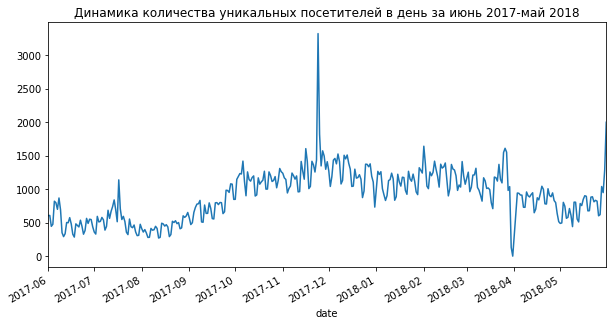

In [25]:
dau.plot(legend=False, figsize=(10,5));
plt.title('Динамика количества уникальных посетителей в день за июнь 2017-май 2018');

Количество новых пользователей очень изменчиво. Особенно выделется пик в декабре 2017 и резкий провад в апреле 2014. Возможно, в этот день были технические неполадки и пользователи не могли попасть на сайт. Резкий рост мог быть вызван не только маркетинговыми решениями, но и внешними причинами: например, аносном концерта популярного исполнителя. Группировка уникальных пользователей по неделям и месяцам поможет оценить общую тенденцию:

In [26]:
wau = wau.reset_index()
wau.index = wau['week']

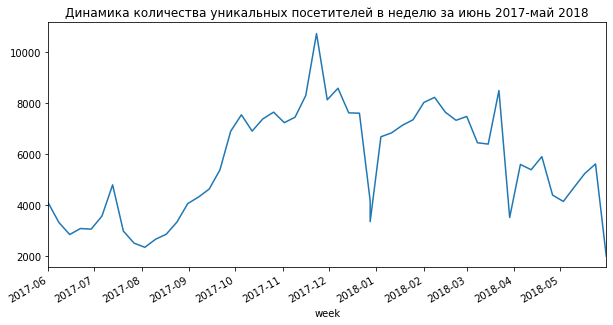

In [27]:
wau['uid'].plot(legend=False, figsize=(10,5));
plt.title('Динамика количества уникальных посетителей в неделю за июнь 2017-май 2018');

Наблюдается резкий спад WAU в конце декабря 2017 года - возможно, здесь сказывается фактор сезонности. Например, потенциальные пользователи были заняты подготовкой к новогодним праздникам и не посещали сайт.

In [28]:
mau = mau.reset_index()
mau.index = mau['month']

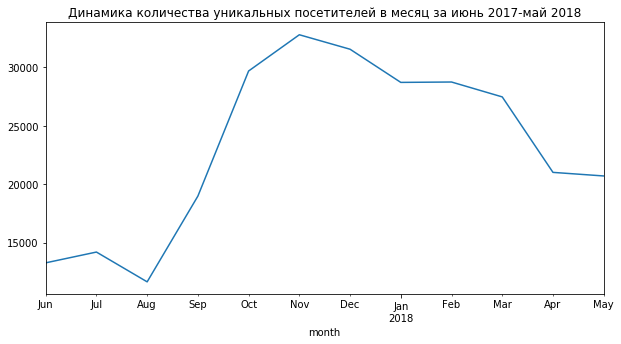

In [29]:
mau['uid'].plot(legend=False, figsize=(10,5));
plt.title('Динамика количества уникальных посетителей в месяц за июнь 2017-май 2018');

Количество новых пользователе резко возросло за период с августа по ноябрь и затем постепенно пошло на спад. На изменение метрик могли повлиять внешние факторы: сезонность, праздники и технические неполадки. В то же время могли сказаться изменения в самом продукте или результаты маркетиноговой стратегии. 

#### Вывод

Чтобы установить причины изменения метрик, подробнее изучать данные показатели: например, в разрезе сегментов пользователей. Тогда можно будет оценить, какой вклад внес каждый сегмент в изменения. Например, можно проанализировать пользователей из разных городов, с разных устройств и т.п. 

В данном исследовании мы будем анализировать метрики в разрезе источников привлечения пользователей. 

#### 2.1.2 Среднее количество сессий в день.

Разделим количество сессий на количество уникальных пользователей по дням и построим график.

In [30]:
df = visits.groupby('date').agg({'uid': ('count', 'nunique')})
df.columns = ['n_sessions', 'n_users']
df['sess_per_user'] = (df['n_sessions']/df['n_users']).round(2)

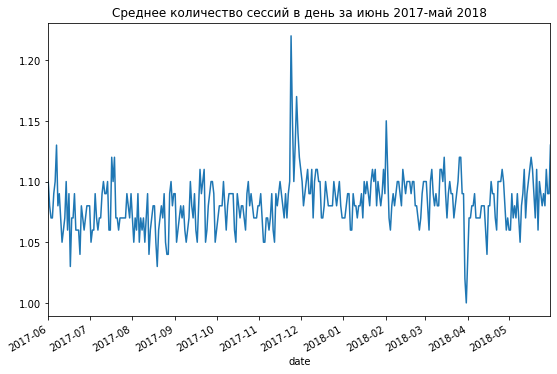

In [31]:
df['sess_per_user'].plot(label='Среднее количество сессий в день', legend=False, figsize=(9,6));
plt.title('Среднее количество сессий в день за июнь 2017-май 2018');

В среднем пользователь заходит один в раз в день, но по динамике среднего за период видим, что количество посещений по дням изменчиво - например, в декабре 2017 было больше всего сессий в день. Скорее всего, это связанно с сезонностью, как мы предполагали ранее при рассмотрении графика DAU.

#### 2.1.3. Продолжительность пользовательской сессии.

Продолжительность сессии в минутах найдем как разность между концом и началом сессии. Посмотрим на распределение.

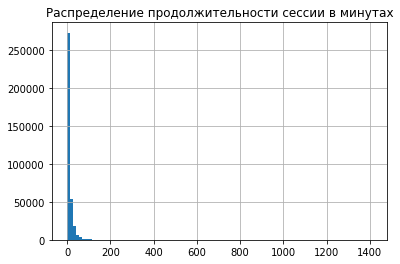

In [32]:
visits['duration'] = ((visits['visit_end'] - visits['visit_start']).dt.seconds)/60
visits['duration'].hist(bins=100);
plt.title('Распределение продолжительности сессии в минутах');

Распределение не похоже на нормальное - видим сильный пик около 1 минуты. Поэтому в качестве меры среднего лучше взять моду - длительность, которая встречается чаще всего.

In [33]:
print('Мода распределения длительности сессии:', visits['duration'].mode()[0])

Мода распределения длительности сессии: 1.0


Наибольшая часть пользователей в среднем проводит на сайте минуту. Возможно, такие пользователи попадают на сайт по ссылке сразу на страницу с покупкой, оформляют заказ и уходят.

#### 2.1.4. Расчет Retention Rate

Для расчета и анализа retention rate когортным методом, необходимо для начала разделить пользователей на когорты. Для этого опредилим для каждого пользователя месяц, когда он впервые посетил сайт. Это станет основой для разделения на когорты.

In [34]:
cohorts = visits.groupby('uid')['visit_start'].min() #находим дату первого визита

In [35]:
cohorts.name = 'first_activity_date'

In [36]:
visits = visits.join(cohorts, on='uid') #добавим найденную информацию в датафрейм visits

In [37]:
#получим месяц из даты первого визита
visits['first_activity_date'] = pd.to_datetime(visits['first_activity_date'])
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')

Теперь для каждой строки датафрейма можно рассчитать lifetime пользователя в рамках когорты.

In [38]:
visits['cohort_lifetime'] = visits['month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime']/np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

Результат группируем по когортам и месяцу lifetime, сохраним в датафрейм visits_by_cohorts.

In [39]:
visits_by_cohorts = visits.groupby(['first_activity_month', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()

Для расчета retention rate нужно знать количество пользователей на начало ее жизненного периода когорты.
Найдем количество для каждой когорты и добавим это в качестве столбца cohort_users к датафрейму visits_by_cogort.

In [40]:
initial_users_count = visits_by_cohorts[visits_by_cohorts['cohort_lifetime'] == 0][['first_activity_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 

In [41]:
visits_by_cohorts = visits_by_cohorts.merge(initial_users_count,on='first_activity_month') 

Наконец, чтобы найти retention rate, осталось разделить количество пользователей в каждый период жизни на изначальное количество пользователей.

In [42]:
visits_by_cohorts['retention'] = visits_by_cohorts['uid']/visits_by_cohorts['cohort_users'] 

Результат представлен в сводной таблице:

In [43]:
visits_by_cohorts['first_activity_month'] = visits_by_cohorts['first_activity_month'].dt.date

In [44]:
retention_pivot = visits_by_cohorts.query('cohort_lifetime > 0').pivot_table(
    index='first_activity_month', 
    columns='cohort_lifetime', 
    values='retention', 
    aggfunc='sum')

In [45]:
retention_pivot

cohort_lifetime,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,
2017-06-01,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Визуально оценить изменение показателя удобно при помощи тепловой карты. Чем светлее графа - тем больше значение показателя, то есть большая доля пользователей продолжает посещать сайт.

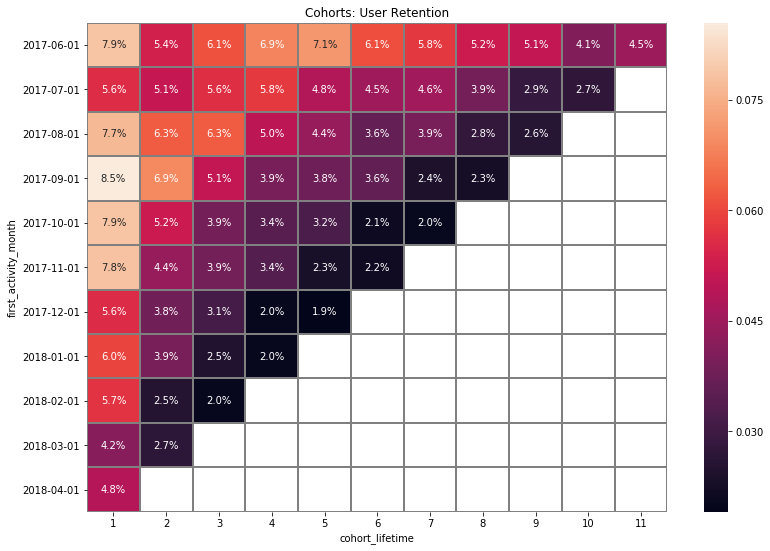

In [46]:
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray'); 

В каждой когорте значения retention rate небольшие. Это необязательно плохой сигнал для бизнеса: многие люди редко посещают мероприятия и у них просто не возникает потребности регулярно смотреть афишу. Для каждой когорты с течением времени данный показатель снижается. Чтобы сделать выводы о том, как это сказывается на бизнесе, стоит посмотреть, снижается ли общее количество пользователей и рентабельность. Вполне вероятно, что низкий retention rate компенсируется постоянным притоком новых пользователей.

По полученной сводной таблице легко составить портрет "типичной" когорты. Например, можно посчитать средний retention rate на второй месяц жизни:

In [47]:
print('Cредний Retention Rate на второй месяц «жизни» когорт: {:.1%}'.format(retention_pivot[1].mean()))

Cредний Retention Rate на второй месяц «жизни» когорт: 6.5%


При сравнении метрик в разрезе источников затрат на привлечение клиентов для удобства мы будем ориентироваться именно на показатели средней когорты.

#### Вывод

На данном этапе складывается следующий портрет пользователя Яндекс.Афиши:
* пользователи в среднем заходят на сайт один раз в день
* вне зависимости от когорты, лишь небольшое количество пользователей возвращается на сайт в последующие месяцы.

### 2.2. Метрики электронной коммерции
#### 2.2.1. Сколько времени проходит с момента первого посещения сайта до совершения покупки?


Для ответа на этот вопрос необходимо найти разность между датой первой покупки и датой первого визита.
На предыдущем шаге мы уже нашли дату первого визита - эта информация хранится в ДФ cohort. Аналогично получим дату первой покупки из ДФ orders и присоединим к cohorts методом join() по колонке uid.

In [48]:
# находим дату первой покупки в виде series, где индекс является uid
first_order_date = orders.groupby('uid')['order_date'].min() 
first_order_date.name = 'first_order_date'

In [49]:
cohorts_df = cohorts.reset_index()

In [50]:
visit_to_order = cohorts_df.join(first_order_date, on='uid') #дополняем дату визита датой покупки
visit_to_order.head()

,uid,first_activity_date,first_order_date
0,11863502262781,2018-03-01 17:27:00,NaT
1,49537067089222,2018-02-06 15:55:00,NaT
2,297729379853735,2017-06-07 18:47:00,NaT
3,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
4,325320750514679,2017-09-30 14:29:00,NaT


В колонке first_order_date появились пропуски, т.к не все посетители сайте совершили покупку. В данном случае можем удалить такие строки, т.к. нас интересуют именно покупатели.
Затем найдем разность между двумя датами в днях и построим распределение

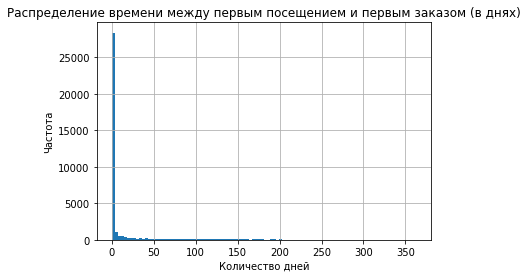

In [51]:
visit_to_order = visit_to_order.dropna()
visit_to_order['days_to_purchase'] = (visit_to_order['first_order_date'] - visit_to_order['first_activity_date']).dt.days
fig = visit_to_order['days_to_purchase'].hist(bins=100);
plt.title('Распределение времени между первым посещением и первым заказом (в днях)');
fig.set_xlabel("Количество дней");
fig.set_ylabel("Частота");

In [52]:
print('Мода:', visit_to_order['days_to_purchase'].mode()[0])

Мода: 0


Т.к. распределение не похоже на нормальное, в качестве средней возьмем моду. Мода равна нулю, то есть большинство пользователей совершают покупку в день своего первого визита. Узнаем, сколько минут на это уходит.

In [53]:
visit_to_order['time_to_purchase'] = (
    (visit_to_order['first_order_date'] - visit_to_order['first_activity_date']).dt.seconds)/60

Построем распределение и найдем его основные характеристики методами describe() и mode():

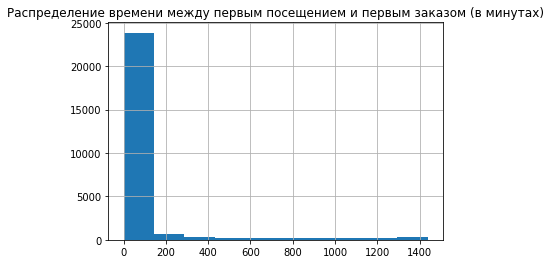

In [54]:
visit_to_order.query('days_to_purchase == 0')['time_to_purchase'].hist();
plt.title('Распределение времени между первым посещением и первым заказом (в минутах)');

In [55]:
visit_to_order['time_to_purchase'].describe()

count    36523.000000
mean       249.164691
std        429.742785
min          0.000000
25%          4.000000
50%         16.000000
75%        252.000000
max       1439.000000
Name: time_to_purchase, dtype: float64

In [56]:
print('Мода:', visit_to_order['time_to_purchase'].mode()[0])

Мода: 1.0


У половины покупателей проходит до 16 минут между первым визитом и покупкой. Но большинство пользователей совершают покупку всего за минуту. Это поддерживает наше предположение о том, что многие пользователи приходят сразу на страницу с покупкой билетов по ссылке с других сайтов (например, с сайта мероприятия) и тратят эту минуту на оформление заказа. Мы считаем это достаточно хорошим показателем.

#### 2.2.2. Cреднее количество покупок на одного покупателя за 6 месяцев.

Чтобы узнать, сколько покупок в среднем совершает один пользователь в месяц, разделим количество заказов в месяц на количество покупателей за месяц.

In [57]:
orders['month'] = orders['order_date'].astype('datetime64[M]') # находим месяц заказа
orders_per_user = orders.groupby('month').agg({'uid': ('count', 'nunique')}) # группируем заказы по месяцам 
#и считаем количество покупок и покупателей
orders_per_user.columns = ['n_orders', 'n_customers']
orders_per_user['orders_average'] = (orders_per_user['n_orders']/orders_per_user['n_customers']).round(2) # расчет среднего
orders_per_user.query('month < "2017-12-01"') # берем данные за 6 месяцев

,n_orders,n_customers,orders_average
month,,,
2017-06-01,2354,2023,1.16
2017-07-01,2363,1984,1.19
2017-08-01,1807,1472,1.23
2017-09-01,3387,2750,1.23
2017-10-01,5679,4675,1.21
2017-11-01,5659,4547,1.24


За рассматриваемый период на покупателя в среднем приходится один заказ, но наблюдается тенденция к увеличению заказов.

#### 2.2.3. Cредний чек

Средний чек - это отношение общей суммы покупок к количество покупателей.

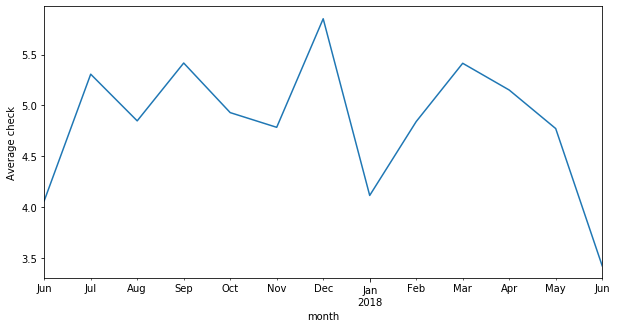

In [58]:
check_df = orders.groupby('month').agg({'revenue': 'sum', 'uid': 'count'})
check_df['avg_check'] = check_df['revenue']/check_df['uid']
plot = check_df['avg_check'].plot(figsize=(10,5));
plot.set_ylabel('Average check');

На графике видно, как по месяцам изменяется средний чек пользователей. Резкие скачки наблюдаются в декабре 2017 и январе 2018 - в среднем пользователи совершают больше покупок в праздничный период, а после праздников покупают совсем мало, но к марту средний чек снова вырастает. К концу периода наблюдается снижение среднего чека, то есть выручка складывается в основном из небольших покупок. 

#### 2.2.4. LTV на покупателя по когортам.

Подготовим таблицу для расчета метрик: LTV, CAC и ROMI.
В таблицу orders добавим месяц первой покупки.

In [59]:
first_order = first_order_date.reset_index()
first_order['first_order_date'] = first_order['first_order_date'].astype('datetime64[M]')

In [60]:
orders_new = pd.merge(orders, first_order, on='uid')

Т.к. в дальнейшем мы будем анализировать метрики в разресе источников трафика, сразу добавим в таблицу информацию об источниках.
Один и тот же пользователь мог прийти из разных источников. Будем считать, что исчтоник первого визита - главный, и именно на него будем ориентироваться в расчетах.
Получим список пользователей и источников их первого посещения.

In [61]:
first_visit_source = visits.sort_values(by='visit_start').groupby('uid').agg({'source_id': 'first'}).reset_index()

Добавляем эту информацию к данным о покупках.

In [62]:
orders_sources = pd.merge(orders_new, first_visit_source, on='uid', how='left')

In [63]:
orders_sources.head()

,order_date,revenue,uid,month,first_order_date,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,3


Уже на этом этапе добавим столбец с затратами на каждый источник в месяц. Нас интересует именно месяц когорты.

In [64]:
costs['month'] = costs['dt'].astype('datetime64[M]') # получили месяц затрат

In [65]:
total_costs = costs.groupby('month')['costs'].sum() # общие затраты в разбивке по месяцам

In [66]:
grouped_costs = costs.groupby(['source_id', 'month'])['costs'].sum() # затраты по месяцам, разбитые по источникам

Т.к. в дальнейшем нужно будет расчитывать метрики отдельно для группы покупателей, пришедних из разных источников, напишем функцию calculate_metrics.
Аргументы функции:
* df: исходные данные - таблица, в которой для каждого пользователя известны выручка, месяц первого посещения, месяц первого заказа, источник
* margin_rate: маржинальность
* costs_data: данные о затратах

Функция из исходных данных посчитает размер когорты и сумму выручки, определиты месяцы lifetime для каждой когорты. Это позволит рассчитать LTV. 
Затем к таблице будут добавленны данные о расходах в месяц, соотвествующий месяцу когорты. Поделив расходы на количество пользователей когорты, узнаем CAC.
Наконец, функция расчитает ROMI как отношение LTV к CAC.

Таким образом, чтобы посчитать метрики в целом по проекту, нужно передать в функцию таблицу orders_sources, маржинальность и таблицу total_costs. Чтобы посчитать метрики для пользователей источника n, в функцию передадим срез orders_sources по номеру источника, маржинальность и затраты grouped_costs, отфильтрованные по номеру источника.

In [67]:
def calculate_metrics(df, margin_rate, costs_data):
    cohort_size = df.groupby('first_order_date').agg({'uid': 'nunique'}).reset_index()
    cohort_revenue = df.groupby(['first_order_date', 'month']).agg({'revenue': 'sum'}).reset_index()
    
    report = pd.merge(cohort_size, cohort_revenue, on='first_order_date')
    
    report['age'] = (report['month'] - report['first_order_date']) / np.timedelta64(1, 'M')
    report['age'] = report['age'].round().astype('int')
    
    report['ltv'] = report['revenue']*margin_rate/report['uid']
    
    report = report.join(costs_data, on='first_order_date')
    report['cac'] = report['costs']/report['uid']
    report['romi'] = report['ltv']/report['cac']

    return report

Функцией report_pivot будем строить сводную таблицу полученных метрик, на основании которой также можно будет построить тепловую карту. В эту функцию необходимо будет передать датафрейм с расчитанными метриками (аргумент report) и указать, какую метрику хотим увидеть в сводной таблице (ltv или romi). Метрики будут посчитаны накопительно на каждый период жизни когорты.

In [68]:
def report_pivot(report, value):
    report['first_order_date'] = report['first_order_date'].dt.date
    report_pivot = report.pivot_table(index='first_order_date', 
                              columns='age', 
                              values=value, 
                              aggfunc='mean').cumsum(axis=1).round(2)
    return report_pivot

Итак, воспользуемся функциями, чтобы найти LTV всего проекта.

In [69]:
total_ltv = calculate_metrics(orders_sources, 1, total_costs)

In [70]:
project_ltv = report_pivot(total_ltv, 'ltv').head(6)

Чтобы проанализировать изменение LTV проекта, построим тепловую карту.

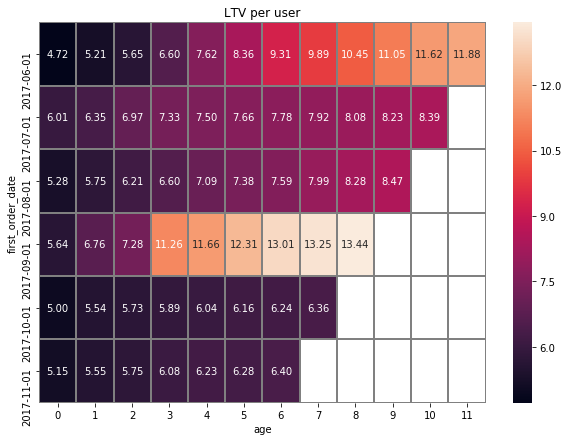

In [71]:
plt.figure(figsize=(10, 7))
plt.title('LTV per user')
sns.heatmap(project_ltv, annot=True, fmt='.2f', linewidths=1, linecolor='gray'); 

Получим средний LTV за 6 месяцев:

In [72]:
project_ltv.mean().head(6)

age
0    5.300000
1    5.860000
2    6.265000
3    7.293333
4    7.690000
5    8.025000
dtype: float64

В целом можно сказать, что со временем пользователи начинают приносить больше выручки. В среднем должно пройти от 3 до 6 месяцев, чтобы показатель начал увеличиваться. Исключением является когорта сентября 2017: в ней рост LTV происходит заметнее всего.

Вывод:
* пользователи в среднем совершают одну покупку в месяц
* средний чек по когортам как уменьшается, так и увеличивается стечением времени, но за редким исключением разница незначительная
* первые три месяца жизни когорты выручка в пересчете на покупателя увеличивается незначительно, но затем растет более быстрыми темпами
* наиболее перспективной выглядит сентябрьская когорта

### 2.3. Маркетинговые метрики

#### 2.3.1. Расходы на маркетинг


In [73]:
costs_total = costs['costs'].sum()
print('Общая сумма расходов на маркетинг за весь период составила: {:.2f}'.format(total_costs.sum()),'у.е.')

Общая сумма расходов на маркетинг за весь период составила: 329131.62 у.е.


Рассмотрим общие расходы в разрезе источников:

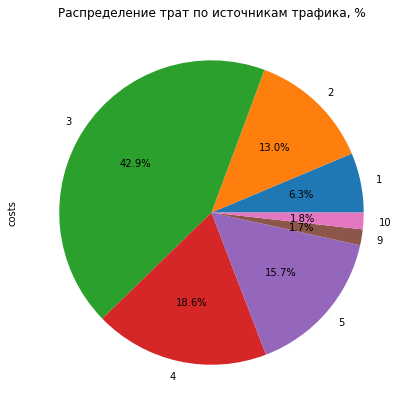

In [74]:
costs.groupby('source_id')['costs'].sum().plot(
    y='flights_amount', 
    kind='pie', 
    figsize=(7,7), 
    legend=False, 
    autopct='%1.1f%%', 
    title='Распределение трат по источникам трафика, %');

Почти половина маркетингового бюджета приходится на источник № 3. Затем почти треть остатка призодится на источники 2, 4 и 5. Меньше всего расходуется на исчтоники 1, 10 и 9.

На графике ниже отображена динамика общих расходов на маркетинг по месяцам за весь период. 

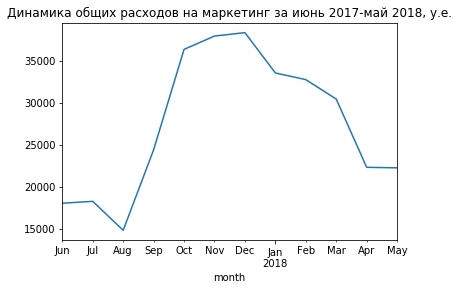

In [75]:
total_costs.plot();
plt.title('Динамика общих расходов на маркетинг за июнь 2017-май 2018, у.е.');

Расходы резко увеличились за август-сентябрь, затем рост немного замедлился. С декабря 2017 суммарные расходы ежемесячно сокращались.

Выясним, как менялись расходы на маркетинг в разрезе источников за рассматриваемый период.
Группируем расходы по источникам и месяцам. Сделаем месяц индексом полученного ДФ, чтобы затем построить график.

In [76]:
costs_by_source = costs.groupby(['source_id', 'month']).sum().sort_values(by=['source_id','month']).reset_index()
costs_by_source.index = costs_by_source['month']

Динамику расходов на каждый источник отобразим на одном графике при помощи цикла, который будет брать номер источника из списка и выделять соответствующий срез затрат.

In [77]:
sources_list = costs_by_source['source_id'].unique()

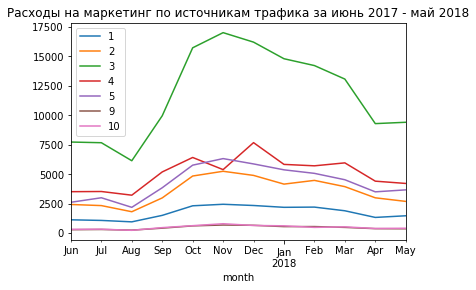

In [78]:
for source in sources_list:
    costs_by_source.query('source_id == @source')['costs'].plot(label=source, legend=True);
    plt.title('Расходы на маркетинг по источникам трафика за июнь 2017 - май 2018');

Если сравнить этот график с предыдущим, становится понятно, что динамика общей суммы расходов была обусловлена в основном расходами на источники № 3 и в меньшей степени № 2, 4 и 5. Был немного увеличен бюджет на источники № 1 и № 10, но в сравнении с другими источниками, на эти варианты затрачено меньше всего средств и каждый месяц сумма мало варьируется.

Вывод:

Динамику расходов следует смотреть не только в целом, но и в разрезе направлений затрат. Также необходимо сопоставить затраты с количеством привлеченных покупателей и полученной от них прибылью, чтобы узнать, насколько они целесообразны.

#### 2.3.2. Затраты на привлечение на одного покупателя.

Затраты на одного покупателя по проекту в целом найдем как отношение суммы затрат к количество новых клиентов в каждом месяце.

In [79]:
monthly_costs = costs.groupby('month')['costs'].sum().reset_index() #сумма затрат по месяцам

In [80]:
buyers = orders.groupby('month').agg({'uid': 'nunique'}).reset_index()
buyers.columns = ['month', 'n_buyers'] # количество уникальных пользователей по месяцам

In [81]:
cac_report = pd.merge(buyers, monthly_costs, on='month', how='left') # объединяем затраты и количество юзеров в одну таблицу

В среднем на привлечение одного пользователя расходуется 8.24 у.е.


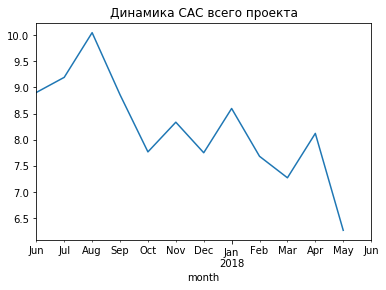

In [82]:
# расчет САС и построение графика
cac_report['cac'] = cac_report['costs']/cac_report['n_buyers']
cac_report.index = cac_report['month']
cac_report['cac'].plot();
plt.title('Динамика CAC всего проекта');
print('В среднем на привлечение одного пользователя расходуется {:.2f} у.е.'.format(cac_report['cac'].mean()))

In [83]:
print('В среднем на привлечение одного пользователя расходуется {:.2f} у.е.'.format(cac_report['cac'].mean()))

В среднем на привлечение одного пользователя расходуется 8.24 у.е.


Затраты на одного покупателя резко снизились за август-сентябрь. На предыдущих графиках мы установили, что в этот период наоборот на привличение клиентов стали расходовать больше средств. Отсюда можно сделать вывод, что в эти месяцы удалось привлечь много пользователей, в следствие чего затраты на одного пользователя резко снизились. В целом эта тенденция сохранилась, несмотря не пики в ноябре, январе и апреле. К концу периода уменьшение САС скорее всего произошло не за счет прироста пользователей, а за счет снижения затрат в целом. 

Полезно рассмотреть динамику САС также в разрезе источников привлечения пользователей.
Для этого найдем:
1) количество пользователей, пришедших через каждый источник в определенный месяц
2) сумму затрат на каждый источник в месяц
3) разделим затраты на количество пользователей и построим общий график для САС каждого источника

In [84]:
costs_by_source = grouped_costs.reset_index() # сумма затрат по источникам

In [85]:
users_by_source = visits.groupby(['first_activity_month', 'source_id']).agg({'uid': 'nunique'}).reset_index()
users_by_source.columns = ['month', 'source_id', 'uid'] # количетсво новых пользователей по источникам

In [86]:
cac_by_source = pd.merge(costs_by_source, users_by_source, on=('month', 'source_id')) # объединям данные в один ДФ

In [87]:
cac_by_source['cac'] = cac_by_source['costs']/cac_by_source['uid'] # расчет САС

In [88]:
cac_by_source.index = cac_by_source['month']

График строим при помощи цикла:

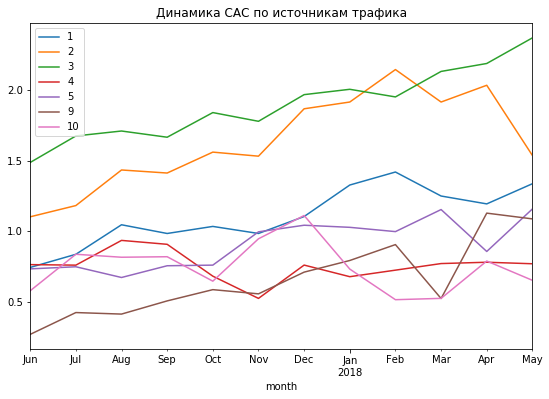

In [89]:
for source in sources_list:
    cac_by_source.query('source_id == @source')['cac'].plot(label=source, legend=True, figsize=(9,6));
    plt.title('Динамика CAC по источникам трафика')

In [90]:
print('Средний CAC по источникам трафика')
cac_by_source.groupby('source_id').agg({'cac': 'mean'}).sort_values(by='cac', ascending=False)

Средний CAC по источникам трафика


,cac
source_id,
3,1.897502
2,1.636301
1,1.105074
5,0.908613
4,0.754880
10,0.747559
9,0.658892


Очевидно, что средние затраты на одного пользователя по-разному менялись в каждом источнике: одновременно росли в одном случае и снижались в другом, "сглаживая" своим эффектом динамику общего САС. 
Стабильно самые высокие затраты на пользователя наблюдаются у 3 источника. Учитывая, что на этот источник тратится больше всего средств, можно предположить, что из этого источника приходит меньше всего пользователей.

Сделать вывод о том, в какой из источников предпочтительнее всего для бизнеса, поможет анализ метрики ROMI, которую расчитаем на следующем шаге.

#### 2.3.3. ROMI по когортам в разрезе источников. 


ROMI в разрезе источников найдем при помощи функций calculate_metrics и report_pivot. Чтобы было удобнее сранивать между собой результаты по источникам, в каждом случае возьмем типичную когорту - т.е. найдем среднее на каждый период жизни.

Результат представлен на графике ниже. По оси Х отложены месяце жизни типичной когорты, по оси У - среднее ROMI.

График построен при помощи цикла, который берет по очереди номер каждого источника из списка и формирует соответствущей срез из таблиц orders_sources и gourped_costs. В каждом случае строится сводная таблица с накопительным ROMI и находится среднее значение по когортам. В результате для каждого источника получаем датафрейм с двумя столбцами: возраст типичной когорты и средний ROMI. 

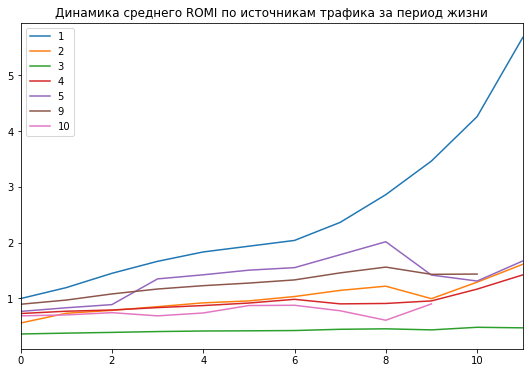

In [91]:
for i in sources_list:
    data = calculate_metrics(orders_sources.query('source_id == @i'), 1, grouped_costs[i])
    temp = report_pivot(data, 'romi').head(6).mean().reset_index()
    temp.columns = ['age', i]
    temp[i].plot(label=i, legend=True, figsize=(9,6))
    plt.title('Динамика среднего ROMI по источникам трафика за период жизни');

На протяжении всего периода жизни когорт источники № 10 и № 3 являются наименее прибыльными. Напомним, что именно на источник № 3 приходится большая часть бюджета. В свою очередь источник № 1 в среднем показывает лучший результат, его ROMI особенно заметно растет после 6 месяца жизни. Источники № 2 и № 4 показывают рост прибыльности с 9 месяца жизни. 

Небольшой и стабильный рост окупаемости показывает источник № 9. Более заметный рост окупаемости наблюдается у источника № 5 на 2-8 месяце жизни, затем окупаемость довольно резко падает. В конце периода окупаемость источников № 5 и № 2 близка, но учитывая предшествующую динамику, источник № 2 выглядит более перспективным.

## Выводы и рекомендации

Проведенное исследование ползволило сделать следующие выводы:

Поведение типичного пользователя:
* В среднем пользователи заходят на сайт раз в день и как правило проводят на сайте одну минуту. 
* Серднее количество посещений в день колеблется за весь период, наблюдаются сезонные пики.
* На одного пользователя приходится в среднем один заказ, но этот показатель имеет тенденцию к росту.
* Большинство пользователей совершают покупку в тот же день. Половина пользователей проводит на сайте до 16 минут, прежде чем совершить покупку.
* В среднем пользователи совершают заказ через минуту после посещения сайта. Мы предполагаем, что эти юзеры пришли сразу на страницу заказа по сторонней ссылке, только чтобы приобрести билеты.
* Динамика количества активных пользователей может быть сильно подвержена внешним факторам. Рекомендуется анализировать данные показатели не только в целом, но и по сегментам пользователей, чтобы определить, чем обусловлены изменения.

Поведение когорт:
* Все когорты показывают низкий retention rate, но мы предполагем, что это обусловлено спецификой бизнеса и не обязательно свидетельствует о проблеме. Тем не менее, рекомендуется продолжить наблюдать за этой метрикой в совокупности с количеством новых пользователей и прибылью.
* Когортный анализ показал, что ценность покупателя становится очевидной не менее, чем за 6 месяцев пользования сервисом.
* Наиболее песрпективной является когорта сентября 2017: в ней выручка от каждого покупателя растет особенно быстро и заметно.

Перспективные источники трафика:
* На наш взгляд, приориетным является источник трафика № 1. Вложения в этот источник окупаются лучше всего и его рентабельность стремительно растет. 
* В будущем можно обратить внимание на источники № 2 и 4: их ROMI начинает увеличиваться в конце исследуемого периода, возможно, они тоже окажутся перспективными источниками трафика. 
* В пользу источника № 1 также свидетельствует тот факт, что у него сравнительно низкие затраты на пользователя.
* Бюджет на источник № 3 следует уменьшить: у него крайне низкая окупаемость, которая почти не меняется со временем. Затраты в пересчете на одного пользователя при этом самые высокие.

